In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime as dt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import plusmodules as pm

from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
#load the dataset
data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


*Let's explore our dataset*

In [3]:
#check the head of the dataset
print("The shape of our dataset is: ", data.shape)

The shape of our dataset is:  (541909, 8)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Our dataset is composed of 541909 rows and 8 columns.  
We noticed that CustomerID has some missing values, as it has only 406829 rows, whereas, Description also has some missing values.  

In [5]:
print("Number of transactions: ", data['InvoiceNo'].nunique())
print("Number of products bought: ",data['StockCode'].nunique())
print("Number of customers:", data['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )
print('Number of countries: ',data['Country'].nunique())

Number of transactions:  25900
Number of products bought:  4070
Number of customers: 4372
Percentage of customers NA:  24.93 %
Number of countries:  38


The number of NA customers is quite large and that would impact the results.

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


Here, we notice that we have some negative values in our dataset.  
Maybe, this could mean that these quantity was returned or cancelled.

*We will look for the list of cancelled invoices and check if there is an invoice with that quantity.  
As mentioned in the description of the dataset, some InvoiceNo start with the letter "c" = cancelled.*

In [7]:
cancelled_orders = data[data['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


*Let's see if our hypothesis is correct about the negative quantity: -80995.*

In [8]:
cancelled_orders[cancelled_orders['Quantity']==-80995]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


As we expected, negative values in the Quantity column, mean that it's a cancelled quantity.  
*Question: How much cancelled orders do we have?*

In [9]:
print("We have ",len(cancelled_orders), " cancelled orders.")
print('Percentage of orders canceled: ',(len(cancelled_orders)*100/data['InvoiceNo'].nunique()))

We have  9288  cancelled orders.
Percentage of orders canceled:  35.86100386100386


### Exploratory Data Analysis

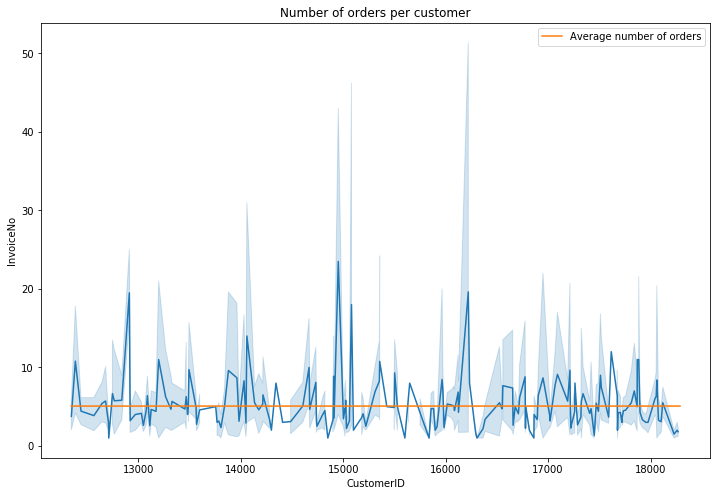

In [10]:
plt.figure(figsize = (12,8))
sns.lineplot(data['CustomerID'], data.groupby('CustomerID')['InvoiceNo'].nunique())
sns.lineplot(data['CustomerID'], data.groupby('CustomerID')['InvoiceNo'].nunique().mean(), label='Average number of orders', linestyle='--')
plt.legend(loc='upper right')
plt.title('Number of orders per customer')
plt.show()

The average number of orders per customer is 5.

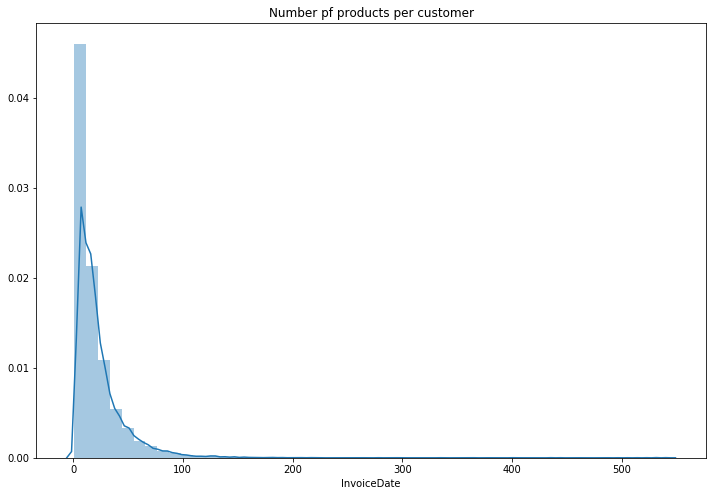

In [11]:
plt.figure(figsize = (12,8))
sns.distplot(data.groupby(['InvoiceNo','CustomerID'])['InvoiceDate'].count())
plt.title('Number pf products per customer')
plt.show()

We have a skewed distribution of products.  
Most people buy less than 25 items.

*What's the total revenue per country?*

In [12]:
data['TotalCost'] = data['Quantity']*data['UnitPrice']
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


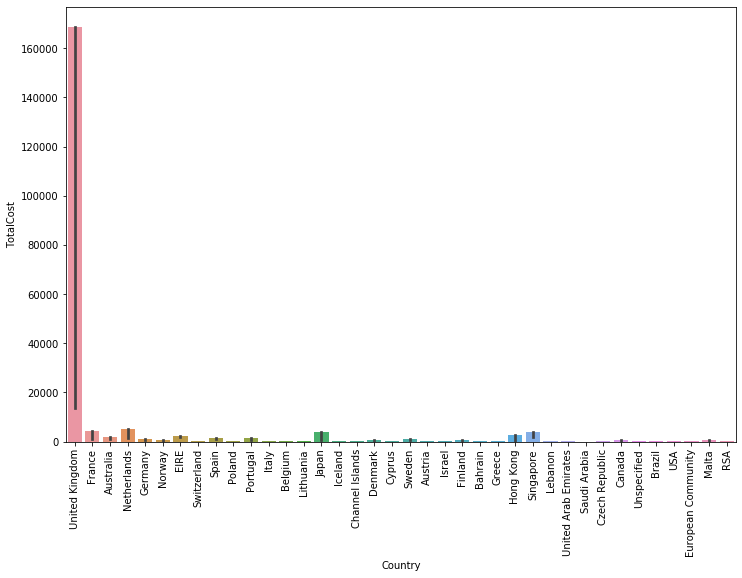

In [13]:
plt.figure(figsize = (12,8))
sns.barplot(x='Country', y='TotalCost', data=data, estimator=max)
plt.xticks(rotation=90)
plt.show()

As we can see, the largest market is the one located in UK.

In [14]:
print('Total number of data from UK: ',len(data[data['Country'] == 'United Kingdom']))
print(round(len(data[data['Country'] == 'United Kingdom'])*100/len(data),2),'% of total data are from UK')
print('Total number of customers form UK: ',data[data['Country']=='United Kingdom']['CustomerID'].nunique())
print(round(data[data['Country']=='United Kingdom']['CustomerID'].nunique()*100/data['CustomerID'].nunique(),2),'% of total customers are from UK')

Total number of data from UK:  495478
91.43 % of total data are from UK
Total number of customers form UK:  3950
90.35 % of total customers are from UK


*So, now we continue with only UK data for our furthur analysis.*

In [15]:
data_uk = data[data['Country']=='United Kingdom']
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [16]:
#check the shape
data_uk.shape

(495478, 9)

In [17]:
#remove canceled orders
data_uk = data_uk[data_uk['Quantity']>0]
data_uk.shape

(486286, 9)

In [18]:
#remove rows where customerID are NA
data_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
data_uk.shape

(354345, 9)

In [19]:
data_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [20]:
#restrict the data to one full year because it's better to use a metric per Months or Years in RFM
data_uk = data_uk[data_uk['InvoiceDate']>= "2010-12-09"]
data_uk.shape

(342478, 9)

In [21]:
print("Summary...")
print("Number of transactions: ", data_uk['InvoiceNo'].nunique())
print("Number of products bought: ",data_uk['StockCode'].nunique())
print("Number of customers:", data_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(data_uk['CustomerID'].isnull().sum() * 100 / len(data_uk),2),"%" )

Summary...
Number of transactions:  16017
Number of products bought:  3611
Number of customers: 3863
Percentage of customers NA:  0.0 %


### RFM Analysis

- RECENCY (R): Days since last purchase 
- FREQUENCY (F): Total number of purchases 
- MONETARY VALUE (M): Total money this customer spent

### Recency

In [22]:
data_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [23]:
current_date = dt.date(2011,12,9)
current_date

datetime.date(2011, 12, 9)

In [24]:
data_uk['Date'] = data_uk['InvoiceDate'].dt.date

In [25]:
data_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost,Date
19632,537879,22114,HOT WATER BOTTLE TEA AND SYMPATHY,12,2010-12-09 08:34:00,3.95,14243.0,United Kingdom,47.4,2010-12-09
19633,537879,22835,HOT WATER BOTTLE I AM SO POORLY,8,2010-12-09 08:34:00,4.65,14243.0,United Kingdom,37.2,2010-12-09
19634,537879,85150,LADIES & GENTLEMEN METAL SIGN,6,2010-12-09 08:34:00,2.55,14243.0,United Kingdom,15.3,2010-12-09
19635,537879,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,4,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,31.8,2010-12-09
19636,537879,21524,DOORMAT SPOTTY HOME SWEET HOME,2,2010-12-09 08:34:00,7.95,14243.0,United Kingdom,15.9,2010-12-09


In [26]:
recency = data_uk.groupby('CustomerID',as_index = False)['Date'].max()
recency.columns = ['CustomerID','LastPurchaseDate']
recency.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [27]:
recency['Recency'] = recency['LastPurchaseDate'].apply(lambda x: (current_date - x).days)

In [28]:
recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [29]:
recency.drop('LastPurchaseDate', axis=1, inplace=True)

### Frequency

In [30]:
data_uk_1 = data_uk
data_uk_1.drop_duplicates(['InvoiceNo','CustomerID'], keep='first', inplace=True)

In [31]:
frequency = data_uk.groupby('CustomerID',as_index = False)['InvoiceNo'].count()
frequency.columns = ['CustomerID','Frequency']
frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,10
2,12748.0,196
3,12749.0,5
4,12820.0,4


### Monetary

In [32]:
monetary = data_uk.groupby('CustomerID', as_index=False)['TotalCost'].sum()
monetary.columns = ['CustomerID','Monetary']
monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,658.89
2,12748.0,3739.23
3,12749.0,98.35
4,12820.0,58.20


### RFM Table

In [33]:
rfm = recency.merge(frequency, on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,10
2,12748.0,0,196
3,12749.0,3,5
4,12820.0,3,4


In [34]:
rfm = rfm.merge(monetary, on='CustomerID')
rfm.set_index('CustomerID',inplace=True)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


### RFM Quartiles

In [35]:
quantiles = rfm.quantile(q=[0.0,0.25,0.75,1])
quantiles

,Recency,Frequency,Monetary
0.00,0.0,1.0,0.00
0.25,17.0,1.0,17.40
0.75,134.0,5.0,121.60
1.00,365.0,196.0,168471.25


In [36]:
quantiles.to_dict()

{'Recency': {0.0: 0.0, 0.25: 17.0, 0.75: 134.0, 1.0: 365.0},
 'Frequency': {0.0: 1.0, 0.25: 1.0, 0.75: 5.0, 1.0: 196.0},
 'Monetary': {0.0: 0.0, 0.25: 17.4, 0.75: 121.6, 1.0: 168471.25}}

### Creating segmentation table

High frequency and monetary value is good for us, where as high recency is bad.  
The simplest way to create customers segmentation from RFM Model is by using Quartiles.

In [37]:
def Rscore(x,p,q):
    if x <= q[p][0.25]:
        return 3
    elif x <= q[p][0.75]:
        return 2 
    else:
        return 1

def FMscore(x,p,q):
    if x <= q[p][0.25]:
        return 1
    elif x <= q[p][0.75]:
        return 2 
    else:
        return 3

In [38]:
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(Rscore, args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMscore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMscore, args=('Monetary',quantiles))
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,3
12747.0,2,10,658.89,3,3,3
12748.0,0,196,3739.23,3,3,3
12749.0,3,5,98.35,3,2,2
12820.0,3,4,58.20,3,2,2


First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [39]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,3,113
12747.0,2,10,658.89,3,3,3,333
12748.0,0,196,3739.23,3,3,3,333
12749.0,3,5,98.35,3,2,2,322
12820.0,3,4,58.20,3,2,2,322


Best Recency score = 3: most recently purchase. Best Frequency score = 3: most quantity purchase. Best Monetary score = 3: spent the most.

In [40]:
rfm_segmentation[rfm_segmentation['RFMScore']=='333'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustomerID,,,,,,,
18102.0,0,57,39646.45,3,3,3,333
17949.0,1,44,28685.69,3,3,3,333
17450.0,8,44,25953.51,3,3,3,333
16013.0,3,45,17163.28,3,3,3,333
16333.0,7,22,14418.96,3,3,3,333
15769.0,7,25,11660.84,3,3,3,333
12901.0,8,28,9230.45,3,3,3,333
13798.0,1,56,7786.26,3,3,3,333
16684.0,4,28,7700.08,3,3,3,333


#### How many customers do we have in each segment?

In [41]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='333']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==3]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==3]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='133']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  356
Loyal Customers:  752
Big Spenders:  966
Almost Lost:  9
Lost Cheap Customers:  353


### Processing data

In [42]:
rfm = rfm.drop(['R_Quartile','F_Quartile','M_Quartile','RFMScore'],axis=1)
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,10,658.89
12748.0,0,196,3739.23
12749.0,3,5,98.35
12820.0,3,4,58.20


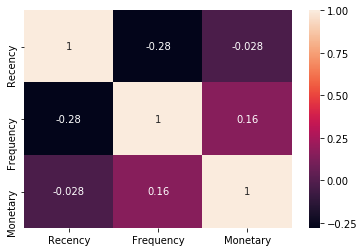

In [43]:
sns.heatmap(rfm.corr(), annot=True)
plt.show()

Here, we have negative correlation between:  
- Recency and Frequency  
- Recency and Manetary 

On the other hand, the correlation between Monetary and Frequency is positive but still not strong.

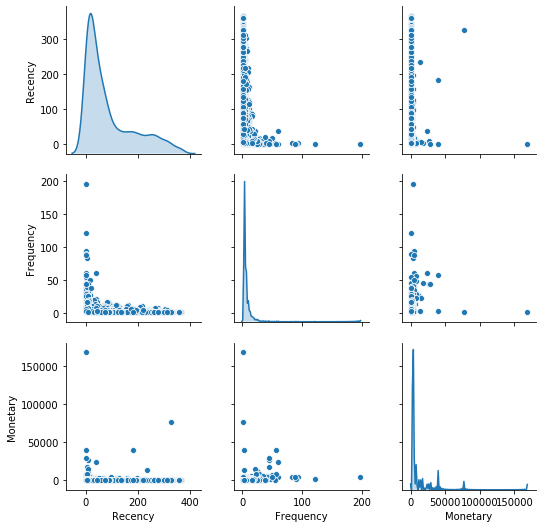

In [44]:
sns.pairplot(rfm, diag_kind='kde')
plt.show()

We can notice that we have **skewed distribution** for all the 3 variables and there exists **outliers**.  

### Data transformation

In [45]:
rfm.skew()

Recency       1.235645
Frequency    10.476247
Monetary     40.156721
dtype: float64

In [46]:
Recency_log = np.log(rfm['Recency']+0.1)
Frequency_log = np.log(rfm['Frequency'])
Monetary_log = np.log(rfm['Monetary']+0.1)

In [47]:
rfm_log = pd.DataFrame({'Recency': Recency_log, 'Frequency': Frequency_log, 'Monetary': Monetary_log})
rfm_log.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,5.784133,0.000000,11.253944
12747.0,0.741937,2.302585,6.490708
12748.0,-2.302585,5.278115,8.226662
12749.0,1.131402,1.609438,4.589549
12820.0,1.131402,1.386294,4.065602


In [48]:
rfm_log.skew()

Recency     -0.857050
Frequency    0.770850
Monetary     0.379215
dtype: float64

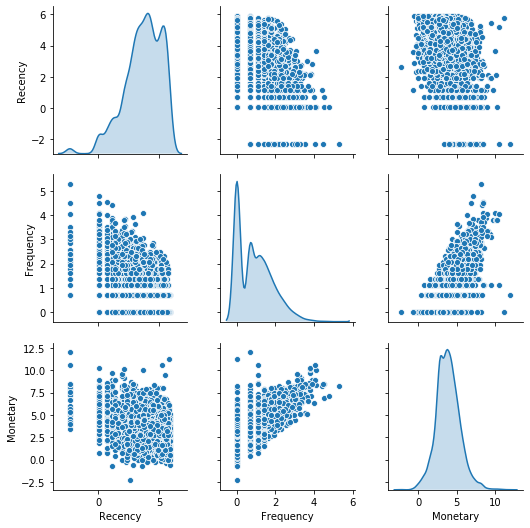

In [49]:
sns.pairplot(rfm_log, diag_kind='kde')
plt.show()

The distributions of Monetary are better, more normalized, but it's not the case with Recency and Frequency distribution, which is improved but not as much. 

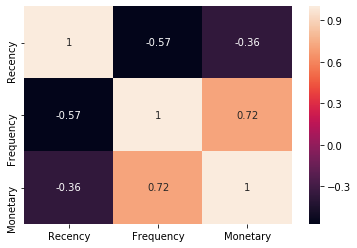

In [50]:
sns.heatmap(rfm_log.corr(), annot=True)
plt.show()

Now, Monetary and Frequency are strongly correlated.

### K-means

In [51]:
rfm_log.describe()

,Recency,Frequency,Monetary
count,3863.000000,3863.000000,3863.000000
mean,3.691822,0.930161,3.882335
std,1.504650,0.892738,1.529366
min,-2.302585,0.000000,-2.302585
25%,2.839078,0.000000,2.862201
50%,3.893859,0.693147,3.808882
75%,4.898586,1.609438,4.801559
max,5.900171,5.278115,12.034521


In [52]:
errors = []
silhouette_scores = []
cluster_range = range(2,16)
for k in cluster_range:
    kmeans = KMeans(n_clusters = k, n_init=50, random_state=0)
    kmeans.fit(rfm_log)
    errors.append([k, kmeans.inertia_])
    label = kmeans.labels_
    ss = silhouette_score(rfm_log, label)
    silhouette_scores.append([k, ss])

In [53]:
Errors = pd.DataFrame(errors, columns=['cluster','errors'])
Errors

,cluster,errors
0,2,11734.336977
1,3,9105.172340
2,4,7378.477553
3,5,6357.418964
4,6,5515.096884
5,7,4881.957763
6,8,4455.178832
7,9,4075.407566
8,10,3739.738971
9,11,3489.277165


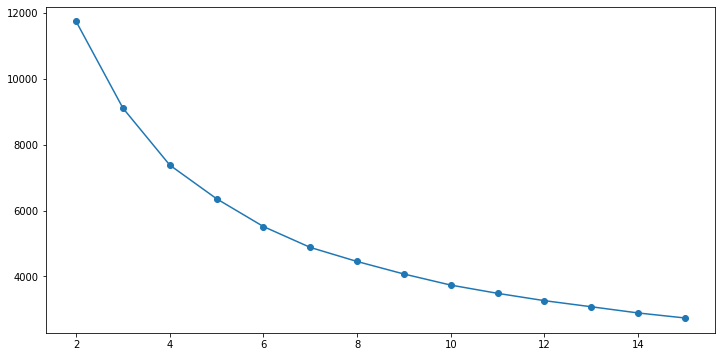

In [54]:
plt.figure(figsize=(12,6))
plt.plot(Errors['cluster'], Errors['errors'], marker = "o" )
plt.show()

In [55]:
Silhouette = pd.DataFrame(silhouette_scores, columns=['cluster','Silhouette_score'])
Silhouette

,cluster,Silhouette_score
0,2,0.389406
1,3,0.303805
2,4,0.310327
3,5,0.290135
4,6,0.295234
5,7,0.291235
6,8,0.292180
7,9,0.295502
8,10,0.298124
9,11,0.291346


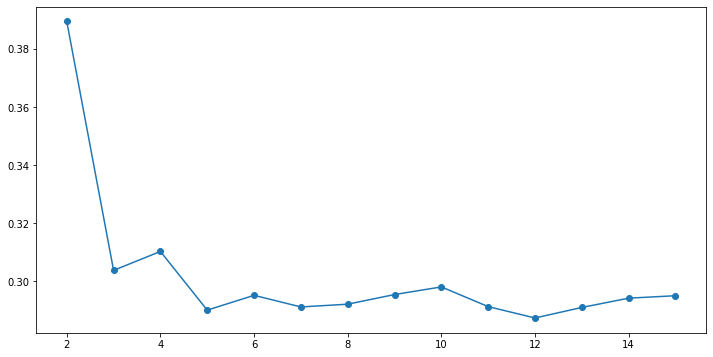

In [56]:
plt.figure(figsize=(12,6))
plt.plot(Silhouette['cluster'], Silhouette['Silhouette_score'], marker = "o" )
plt.show()

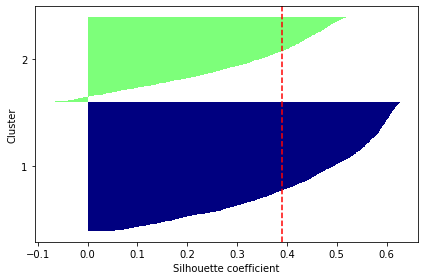

In [57]:
pm.svisualizer(rfm_log, 2)

In [61]:
kmeans = KMeans(n_clusters = 2, n_init=50, random_state=0)
kmeans.fit(rfm_log)

labels = kmeans.predict(rfm_log)
centroids = kmeans.cluster_centers_

print('Centroid values \n',centroids)

Centroid values 
 [[4.46208719 0.40746136 3.06172263]
 [2.51091643 1.73152073 5.14042868]]


In [69]:
rfm_kmeans = rfm_log
rfm_kmeans['Cluster'] = labels
rfm_kmeans.head()

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,5.784133,0.000000,11.253944,1
12747.0,0.741937,2.302585,6.490708,1
12748.0,-2.302585,5.278115,8.226662,1
12749.0,1.131402,1.609438,4.589549,1
12820.0,1.131402,1.386294,4.065602,1


In [74]:
rfm_kmeans['Cluster'].value_counts()

0    2337
1    1526
Name: Cluster, dtype: int64

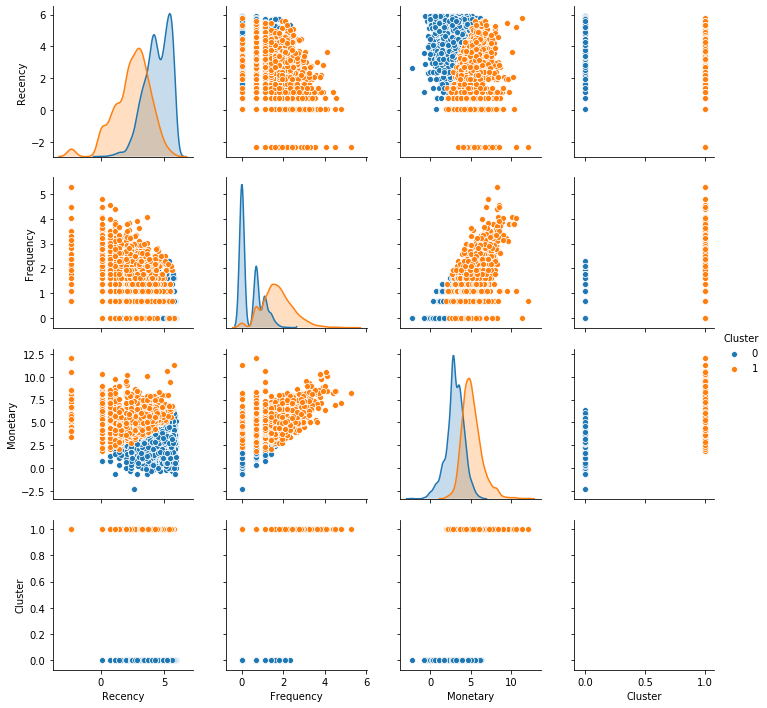

In [76]:
sns.pairplot(rfm_kmeans,diag_kind='kde',hue='Cluster')

### Agglomerative Clustering

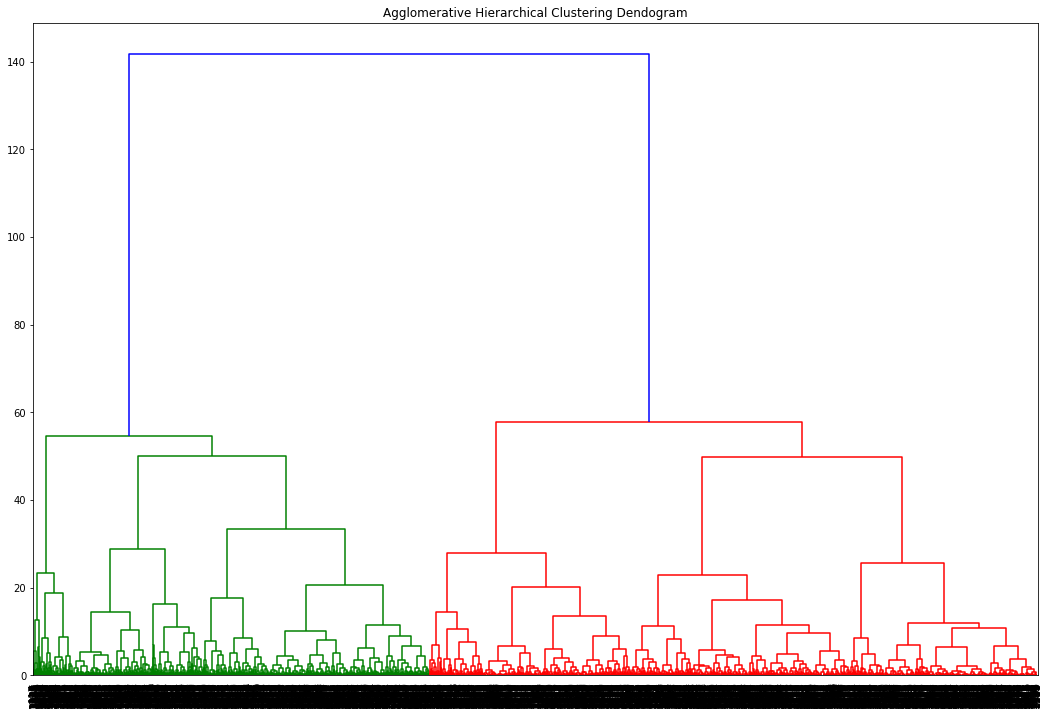

In [78]:
plt.figure(figsize=(18, 12))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
merging = linkage(rfm_log, 'ward')
dendrogram(merging,leaf_rotation=90.0,p=25,color_threshold=80,leaf_font_size=10)
plt.show()

The **best silhouette score** obtained is when the **number of clusters is 2**.